# PE - Financial Sentiment Analysis

## Data preparation

In [59]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random
import numpy as np

In [60]:
DATA_PATH = './dataset/data.csv'

In [61]:
df = pd.read_csv(DATA_PATH)
df.head(10)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


In [67]:
positive = random.sample(np.argwhere((df['Sentiment']=='positive').to_numpy()).ravel().tolist(), 20)
neutral = random.sample(np.argwhere((df['Sentiment'] == 'neutral').to_numpy()).ravel().tolist(), 20)
negative = random.sample(np.argwhere((df['Sentiment'] == 'negative').to_numpy()).ravel().tolist(), 20)
samples_idx = positive + neutral + negative
samples = df.iloc[samples_idx]
samples.shape

(60, 2)

## Language model init

In [63]:
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import ChatPromptTemplate
from langchain.prompts import FewShotChatMessagePromptTemplate
from langchain.schema import BaseOutputParser

In [104]:
from dotenv import load_dotenv
import os

load_dotenv()
API_KEY=os.getenv("API_KEY")

In [106]:
chat_model = ChatOpenAI(openai_api_key= API_KEY)

In [25]:
# Output parser class. 
class OutputParser(BaseOutputParser):
    def parse(self, text):
        labels = ['positive', 'negative', 'neutral']
        split_res = list(map(str.lower, text.strip('.').split(' ')))
        label_idx = np.argwhere(np.isin(labels, split_res)).ravel()
        return labels[label_idx[0]]


## Zero-shot

In [66]:
# Zero-shot prompt.
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "Classify the sentiment of the sentence. Respond positive, netgative, and neutral only."),
        ("human", "{input_sentence}")
    ]
)

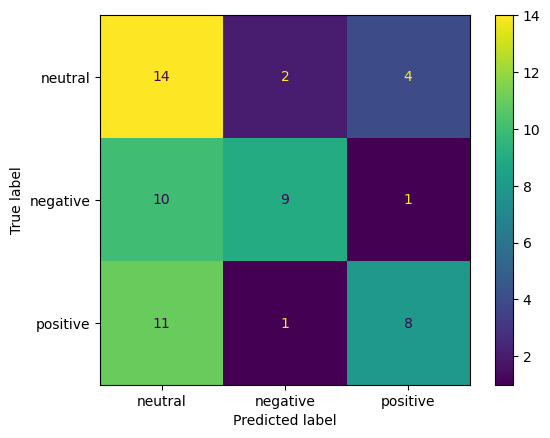

In [22]:
chain = prompt | chat_model | OutputParser()
y_pred = []
for i, row in samples.iterrows():
    pred = chain.invoke({"input_sentence":row['Sentence']})
    y_pred.append(pred)

cm = confusion_matrix(samples['Sentiment'], y_pred, labels=['neutral', 'negative', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral', 'negative', 'positive'])
disp.plot()

## Few-shot

In [65]:
# Seperate few-shot examples and testing set.
def generate_examples(dataset: DataFrame, shot: int):
    examples = dataset.sample(shot)
    testing_samples = dataset.drop(examples.index)
    prompt_examples = examples.to_dict(orient='records')
    return prompt_examples, testing_samples

In [9]:
# Generate few-shot example prompt.
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{Sentence}"),
        ("ai", "{Sentiment}")
    ]
)

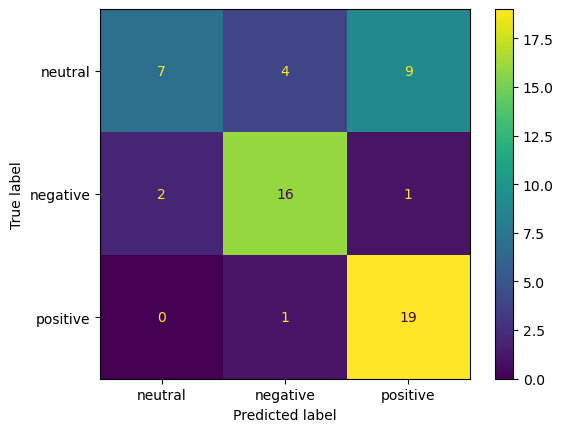

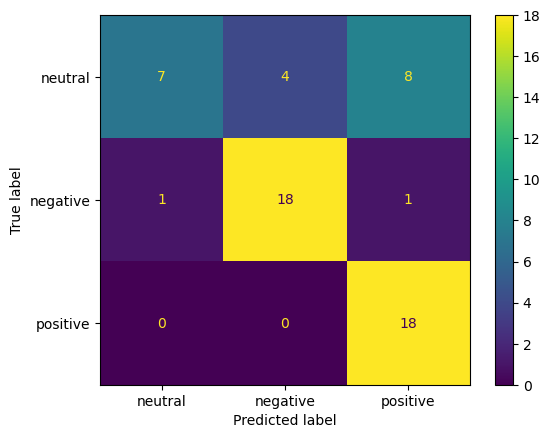

In [11]:
shots = [1,3]
for s in shots:
    examples, testing_samples = generate_examples(samples, s)
    few_shot_prompt = FewShotChatMessagePromptTemplate(
        example_prompt=example_prompt,
        examples=examples,
    )
    final_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "Classify the sentiment of the sentence. Respond positive, negative, and neutral only."),
            few_shot_prompt,
            ("human", "{Sentence}"),
        ]
    )
    few_shot_chain = final_prompt | chat_model | OutputParser()
    preds = []
    for i, row in testing_samples.iterrows():
        pred = few_shot_chain.invoke({"Sentence": row['Sentence']})
        preds.append(pred)
    cm = confusion_matrix(testing_samples['Sentiment'], preds, labels=['neutral', 'negative', 'positive'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral', 'negative', 'positive'])
    disp.plot()

### Chain of Thoughts

In [86]:
from langchain.prompts import PromptTemplate

# Chain of thoughts template.
cot_prompt = PromptTemplate.from_template(
    """
        Here is a sentence relates to finance:
        {Sentence}
        Predict the sentiment of the sentence and tell me why.
        
        Please generate the following format:
        reason: the reason why the label should be positive/negative/neutral
        label: the label based on the reason
    """
)

In [93]:
import re
class CoTOutputParser(BaseOutputParser):
    def parse(self, text):
        label = re.search(r"label:\s?(positive|negative|neutral)", text)
        return label.group(1).lower() if label is not None else None

In [94]:
rg = r"label:\s?(positive|negative|neutral)"
match = re.search(rg, "acbsabndwuhqiuhdiw label:positiveu")
print(match)

<re.Match object; span=(19, 33), match='label:positive'>


In [95]:
# CoT prediction
cot_chain = cot_prompt | chat_model | CoTOutputParser()
preds = []
for i, row in samples.iterrows():
    pred = cot_chain.invoke({"Sentence": row['Sentence']})
    preds.append(pred)

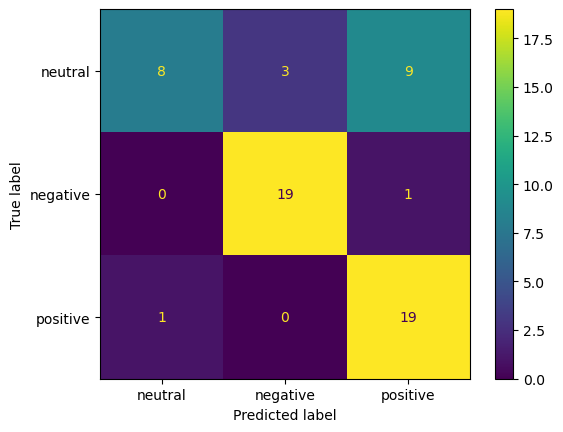

In [97]:
cm = confusion_matrix(samples['Sentiment'], preds, labels=['neutral', 'negative', 'positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutral', 'negative', 'positive'])
disp.plot()
